# Lib

In [15]:
from dotenv import load_dotenv

import pandas as pd
import numpy as np
import json
import os
import seaborn as sns
from matplotlib.patches import Rectangle
import json
import pandas as pd
import matplotlib.pyplot as plt
# from skimage.io import imread
from matplotlib.collections import PatchCollection
from matplotlib.patches import Rectangle
from PIL import Image, ImageDraw
# import cv2

# from fastai.vision import *
# from IPython.core.display import HTML
# # HTML("<style>div.output_area pre {white-space: pre;}</style>")
# import ipywidgets as widgets
# from IPython.display import display
import ee

from utils.functions import *
from utils.functions_satellite_image import *

%matplotlib inline  


# Google Map Authorization

In [5]:
'''Authenticate and initialize'''
#=======================
# Load environment variables from .env file
load_dotenv()

GOOGLE_APPLICATION_CREDENTIALS = os.getenv("GOOGLE_APPLICATION_CREDENTIALS")
SERVICE_ACCOUNT = os.getenv("SERVICE_ACCOUNT")

credentials = ee.ServiceAccountCredentials(SERVICE_ACCOUNT, GOOGLE_APPLICATION_CREDENTIALS)
ee.Initialize(credentials)

print("Earth Engine initialized")


Earth Engine initialized


# Functions

In [5]:
def replace_name_of_categori(x):
  if x == 0:
    return 'roof-panel'
  if x ==1 :
    return 'panel'
  if x ==2:
    return 'roof'

In [6]:
import os

folder = r'/content/drive/MyDrive/Proactiveware/data/for_YOLO_v6/sym'

# Iterate
i = 1 
for file in os.listdir(folder):
	# Checking if the file is present in the list
	# if file in filesRename:
  oldName = os.path.join(folder, file)
  n = os.path.splitext(file)[0]

  b = str(i) + '_new' + '.jpg'
  newName = os.path.join(folder, b)
  i = i+1
  # Rename the file
  os.rename(oldName, newName)

res = os.listdir(folder)
# print(res)

In [7]:
def calculate_aspect_ratios(annotations):
    aspect_ratios = []

    for annotation in annotations:
        # Assuming annotation is in the format [x, y, width, height]
        width = annotation[2]
        height = annotation[3]
        aspect_ratio = float(width) / height
        aspect_ratios.append(aspect_ratio)

    return aspect_ratios


# Read data

In [8]:
path_ = "data/roof_panel.v6i.coco/"
json_path = os.path.join(path_ + 'train', '_annotations.coco.json')
with open(json_path, 'r') as f:
    annot_data_train = json.load(f)

json_path = os.path.join(path_ + 'valid', '_annotations.coco.json')
with open(json_path, 'r') as f:
    annot_data_valid = json.load(f)

json_path = os.path.join(path_ +'test', '_annotations.coco.json')
with open(json_path, 'r') as f:
    annot_data_test = json.load(f)

In [9]:
annot_data_train.keys()

dict_keys(['info', 'licenses', 'categories', 'images', 'annotations'])

In [10]:
annot_data_train["info"]

{'year': '2023',
 'version': '6',
 'description': 'Exported from roboflow.ai',
 'contributor': '',
 'url': 'https://public.roboflow.ai/object-detection/undefined',
 'date_created': '2023-05-19T16:22:37+00:00'}

In [11]:
annot_data_train['licenses']

[{'id': 1,
  'url': 'https://creativecommons.org/licenses/by/4.0/',
  'name': 'CC BY 4.0'}]

In [12]:
annot_data_train["categories"]

[{'id': 0, 'name': 'roof-panel', 'supercategory': 'none'},
 {'id': 1, 'name': 'panel', 'supercategory': 'roof-panel'},
 {'id': 2, 'name': 'roof', 'supercategory': 'roof-panel'}]

In [13]:
annot_data_train["images"][2]["file_name"]

'map_39-130216788921906_-94-66408927609203_39-130908593754484_-94-66283400227306_500_500_png.rf.9be9a00ededde91f8d466456cf9a0e5a.jpg'

In [16]:
df_train = pd.DataFrame(annot_data_train['annotations'])
df_valid = pd.DataFrame(annot_data_valid['annotations'])
df_test = pd.DataFrame(annot_data_test['annotations'])

print("df_train shape:", df_train.shape)
print("df_valid shape:", df_valid.shape)
print("df_test shape:", df_test.shape)

df_train["category_name"] = df_train["category_id"].apply(lambda x : replace_name_of_categori(x))
df_valid["category_name"] = df_train["category_id"].apply(lambda x : replace_name_of_categori(x))
df_test["category_name"] = df_train["category_id"].apply(lambda x : replace_name_of_categori(x))

df_train.sample(10)

df_train shape: (8044, 7)
df_valid shape: (637, 7)
df_test shape: (389, 7)


,id,image_id,category_id,bbox,area,segmentation,iscrowd,category_name
4568,4568,693,2,"[228, 101, 120.32, 60.8]",7315.456,"[[296.32, 110.08, 291.2, 102.4, 269.44, 101.12...",0,roof
6657,6657,970,1,"[24, 448, 14.154, 15.446]",218.624,"[[24.422, 459.307, 38.485, 463.588, 38.576, 45...",0,panel
5566,5566,825,1,"[344, 89, 10.278, 15.107]",155.278,"[[351.52, 103.92, 354.261, 93.848, 347.752, 88...",0,panel
1765,1765,301,2,"[545, 1, 94.72, 208.64]",19762.381,"[[640, 0.64, 598.4, 1.28, 595.84, 6.4, 574.08,...",0,roof
2233,2233,378,2,"[612, 503, 28.287, 56.612]",1601.401,"[[640, 503.352, 611.713, 537.871, 640, 559.964...",0,roof
2477,2477,413,2,"[345, 384, 242.454, 235.086]",56997.610,"[[527.62, 450.026, 512.616, 480.134, 494.445, ...",0,roof
7517,7517,1077,2,"[0, 4, 640, 634.386]",406007.018,"[[626.03, 589.474, 632.558, 589.474, 640, 522....",0,roof
7791,7791,1124,1,"[264, 130, 15.643, 87.785]",1373.228,"[[275.222, 217.805, 279.621, 152.381, 274.244,...",0,panel
7780,7780,1121,1,"[632, 77, 7.68, 19.84]",152.371,"[[640, 77.44, 635.52, 76.8, 632.32, 94.08, 640...",0,panel
6486,6486,944,2,"[0, 8, 640, 632.191]",404602.241,"[[640, 313.277, 629.833, 275.371, 625.478, 176...",0,roof


# Lets see what we have

In [17]:
print("in avearge polygons in train set have number of vertecis:",df_train["segmentation"].apply(lambda x: len(x[0])).mean())
print("in avearge polygons in valid set have number of vertecis:",df_valid["segmentation"].apply(lambda x: len(x[0]) if len(x) !=0 else 0).mean())
print("in avearge polygons in test set have number of vertecis:",df_test["segmentation"].apply(lambda x: len(x[0]) if len(x) !=0 else 0).mean())

in avearge polygons in train set have number of vertecis: 21.434361014420688
in avearge polygons in valid set have number of vertecis: 23.899529042386185
in avearge polygons in test set have number of vertecis: 22.868894601542415


In [18]:
print("number of images in train set:",len(df_train["image_id"].unique().tolist()))
print("number of images in valid set:",len(df_valid["image_id"].unique().tolist()))
print("number of images in test set:",len(df_test["image_id"].unique().tolist()))

number of images in train set: 1129
number of images in valid set: 109
number of images in test set: 59


In [19]:
# print("in avearge how many polygons exist in each image",df_train.groupby("image_id").count()["id"].mean())

In [20]:
sns.barplot(data = df_train.groupby("category_name").count()["id"].to_frame().reset_index(),  x="category_name", y="id")
plt.title("distribution of categories in train data")

NameError: name 'sns' is not defined

Text(0.5, 1.0, 'distribution of categories in validation data')

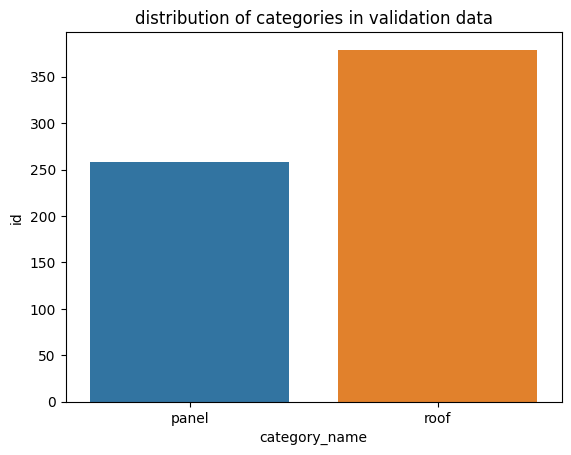

In [ ]:
sns.barplot(data = df_valid.groupby("category_name").count()["id"].to_frame().reset_index(),  x="category_name", y="id")
plt.title("distribution of categories in validation data")

Text(0.5, 1.0, 'distribution of categories in test data')

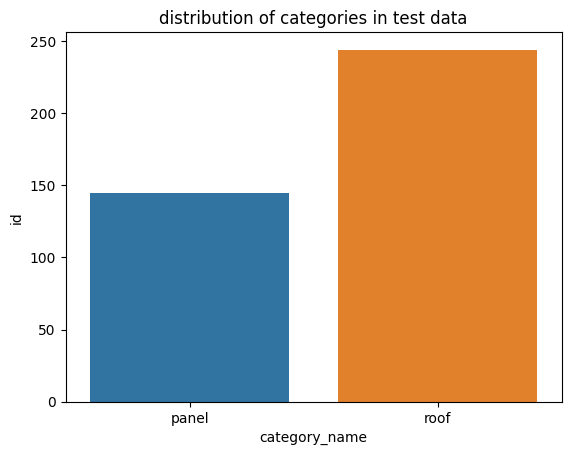

In [ ]:
sns.barplot(data = df_test.groupby("category_name").count()["id"].to_frame().reset_index(),  x="category_name", y="id")
plt.title("distribution of categories in test data")

# Lets see general view of our images

In [ ]:
# # from fastai.vision import *
# li = EasyImageList.from_folder('/content/drive/MyDrive/Proactiveware/data/for_YOLO_v6/sym')
# # li.symlink_images()
# li.html(sample = 100, size = 40, by_class=True)
# # print out the list of image paths
# print(image_list.images)

# # convert image paths to HTML code for display
# html_code = image_list.html(sample = 100, size = 40, by_class=True)

# # display HTML code as output
# print(html_code)


# Plot image with box and polygons of each segmentation

image general info:
width:   640
height:  640
channel: 3




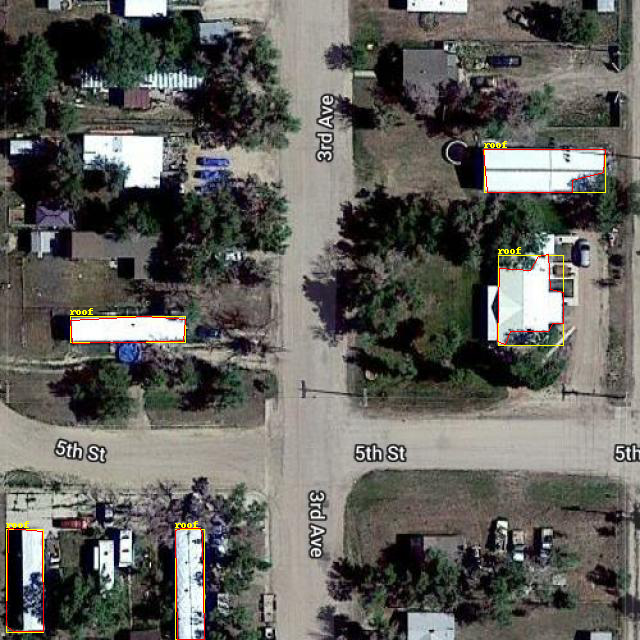

In [ ]:
"""select number of image that want to see"""
image_id = 100


"""select on of the line to plot image from train or validation or test data set"""
df = df_train[df_train["image_id"]== image_id]
# df = df_val[df_train["image_id"]== image_id]
# df = df_test[df_train["image_id"]== image_id]


"""Lets see it"""
file_name = annot_data_train["images"][image_id][ 'file_name']
image = Image.open('/content/drive/MyDrive/Proactiveware/data/for_coco_v6/train/{}'.format(file_name))
# Create a drawing context
draw = ImageDraw.Draw(image)

im = cv2.imread('/content/drive/MyDrive/Proactiveware/data/for_coco_v6/train/{}'.format(file_name))
print("general information about image")
h, w, c = im.shape
print('width:  ', w)
print('height: ', h)
print('channel:', c)
print("\n")

for i, row in df.iterrows():
  bbox = row['bbox']  
  segmentation = row["segmentation"][0]
  pair_of_tuples = [(segmentation[i], segmentation[i+1]) for i in range(0, len(segmentation), 2)]

  draw.rectangle((bbox[0], bbox[1], 
                bbox[0] + bbox[2], bbox[1] + bbox[3]), 
                outline='yellow')

  draw.polygon(pair_of_tuples, outline='red')

  category = row["category_name"]
  draw.text((bbox[0], bbox[1] - 10), category,  fill='yellow')

image

# aspect ratio

In [ ]:
"""In the context of object detection, the aspect ratio typically refers to the
 aspect ratio of bounding boxes or masks that enclose objects of interest
within an image. For example, if a bounding box has a width of 200 pixels 
and a height of 100 pixels, the aspect ratio would be 2:1.

Aspect ratio is an important property to consider in image processing and
computer vision tasks. It provides information about the shape and orientation
of objects in an image. Analyzing aspect ratios can help identify patterns or
characteristics of objects, detect outliers, or guide the design of object 
detection algorithms.

By examining the aspect ratios of objects in a dataset, you can gain insights 
into the typical shapes or orientations of those objects and use this knowledge 
to inform your object detection models or tailor your image processing
 techniques accordingly."""


"""select number of image that want to compute aspect of ratio for it"""
image_id = 500


"""select on of the line to compute  aspect of ratio from train or validation or test data set"""
df = df_train[df_train["image_id"]== image_id]
# df = df_val[df_train["image_id"]== image_id]
# df = df_test[df_train["image_id"]== image_id]

ll = list()
for i, row in df.iterrows():
  x = row["segmentation"][0]
  ll.append(x)
ll
annotations = ll
aspect_ratios = calculate_aspect_ratios(annotations)
print("Aspect Ratios:", aspect_ratios)
print("Mean Aspect Ratio:", np.mean(aspect_ratios))
print("Max Aspect Ratio:", np.max(aspect_ratios))
print("Min Aspect Ratio:", np.min(aspect_ratios))


Aspect Ratios: [0.0, 3.0292969567270616, 1.0282810746028521, 0.6713207633727865, 0.9802642711575106]
Mean Aspect Ratio: 1.1418326131720424
Max Aspect Ratio: 3.0292969567270616
Min Aspect Ratio: 0.0
